<a href="https://colab.research.google.com/github/MahmoudHabibForsan/MahmoudHabibForsan.github.io/blob/master/Project_1_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setup Kaggle Dataset

In [ ]:
from google.colab import files
files.upload()  # Upload kaggle.json

import os
import zipfile
import shutil

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!pip install -q kaggle
!kaggle datasets download -d alistairking/recyclable-and-household-waste-classification

with zipfile.ZipFile("recyclable-and-household-waste-classification.zip", 'r') as zip_ref:
    zip_ref.extractall("waste_data")

Imports

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import os
import itertools
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Set Constants
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
DATA_DIR = "/content/waste_data/images/images"
SEED = 123
AUTOTUNE = tf.data.AUTOTUNE


Loading Dataset

In [16]:
train_ds = image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
num_classes = len(class_names)


Found 15000 files belonging to 30 classes.
Using 12000 files for training.
Found 15000 files belonging to 30 classes.
Using 3000 files for validation.


Augmentation

In [17]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])


Build and Train Functions

In [18]:
def build_model(base_model_class, optimizer='adam', fine_tune=False, fine_tune_at=100):
    preprocess_input = tf.keras.applications.efficientnet.preprocess_input
    if base_model_class == tf.keras.applications.ResNet50:
        preprocess_input = tf.keras.applications.resnet50.preprocess_input
    elif base_model_class == tf.keras.applications.MobileNetV2:
        preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

    base_model = base_model_class(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,))
    base_model.trainable = fine_tune

    if fine_tune:
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False

    inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Define Models and Optimizers to Compare
models_to_train = {
    "EfficientNetB0": tf.keras.applications.EfficientNetB0,
    "ResNet50": tf.keras.applications.ResNet50,
    "MobileNetV2": tf.keras.applications.MobileNetV2,
}

optimizers = ['adam', 'sgd', 'rmsprop']

# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True)
]

Train Models

In [19]:
import gc

for name, model_class in models_to_train.items():
    for opt in optimizers:
        print(f"\n Training {name} with {opt.upper()} optimizer...")
        model = build_model(model_class, optimizer=opt, fine_tune=True, fine_tune_at=100)
        history = model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=callbacks)
        history_dict[f"{name}_{opt}"] = (model, history)

        # Free memory after each training (it crashed)
        tf.keras.backend.clear_session()
        gc.collect()



 Training EfficientNetB0 with ADAM optimizer...
Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 115s 205ms/step - accuracy: 0.5838 - loss: 1.4524 - val_accuracy: 0.7977 - val_loss: 0.6384
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 136s 203ms/step - accuracy: 0.8089 - loss: 0.6015 - val_accuracy: 0.7993 - val_loss: 0.6513
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 84s 210ms/step - accuracy: 0.8332 - loss: 0.4901 - val_accuracy: 0.8137 - val_loss: 0.6253
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 75s 192ms/step - accuracy: 0.8677 - loss: 0.3841 - val_accuracy: 0.8250 - val_loss: 0.5607
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 85s 199ms/step - accuracy: 0.8854 - loss: 0.3364 - val_accuracy: 0.8160 - val_loss: 0.6595
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 82s 198ms/step - accuracy: 0.8947 - loss: 0.2942 - val_accuracy: 0.8190 - val_loss: 0.6467
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 76s 182ms/step - accuracy: 0.9021 - loss: 0.2770 - val_accuracy: 0.8300 - val_loss: 0.6000

 Training EfficientNetB0 with S

Plot Accuracy and Loss

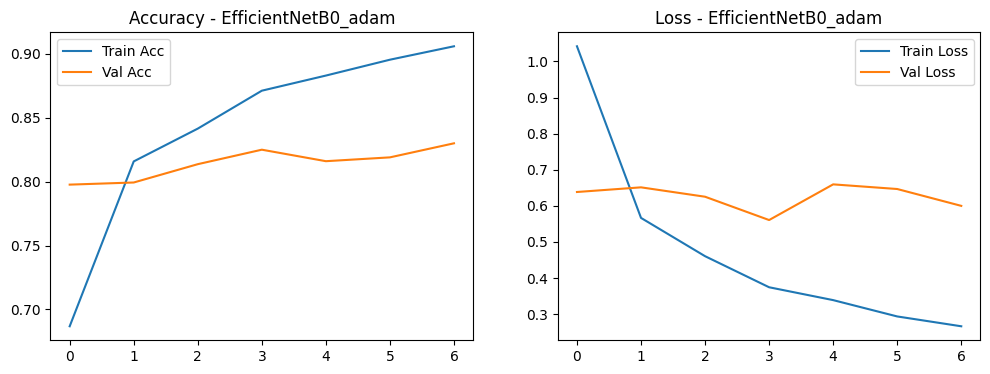

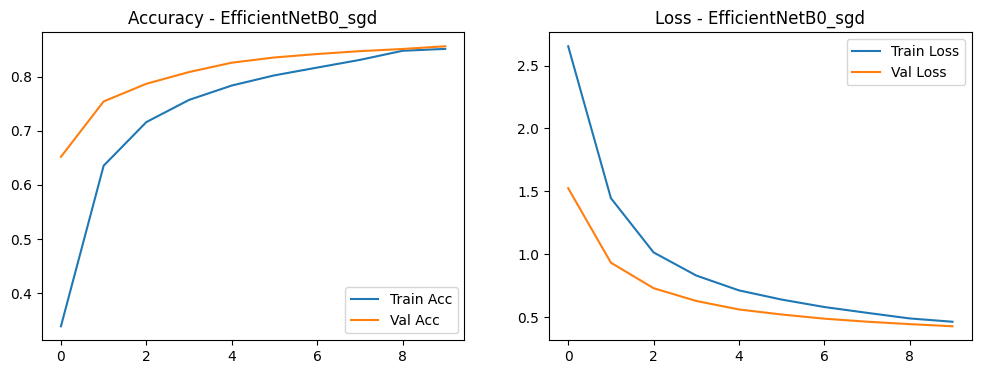

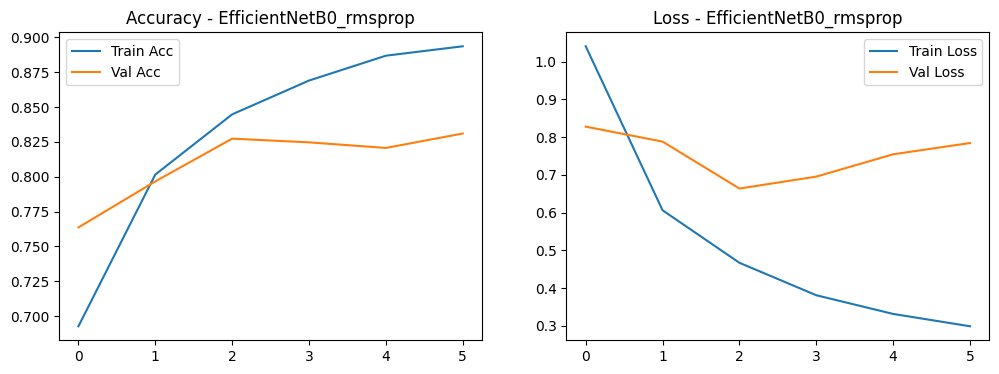

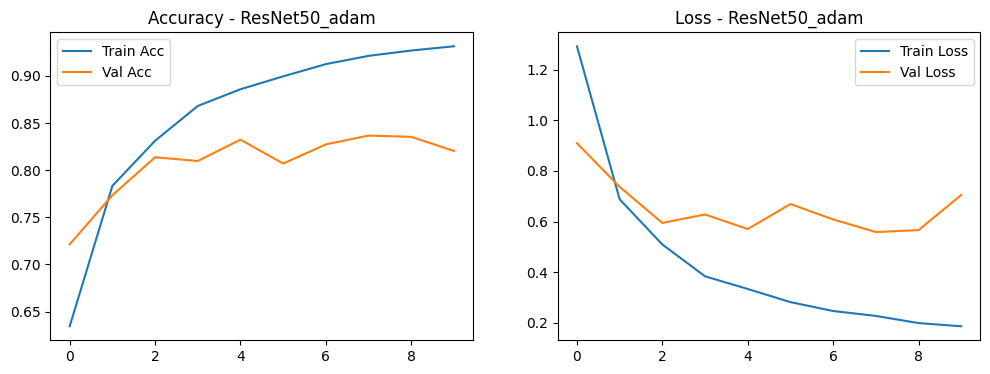

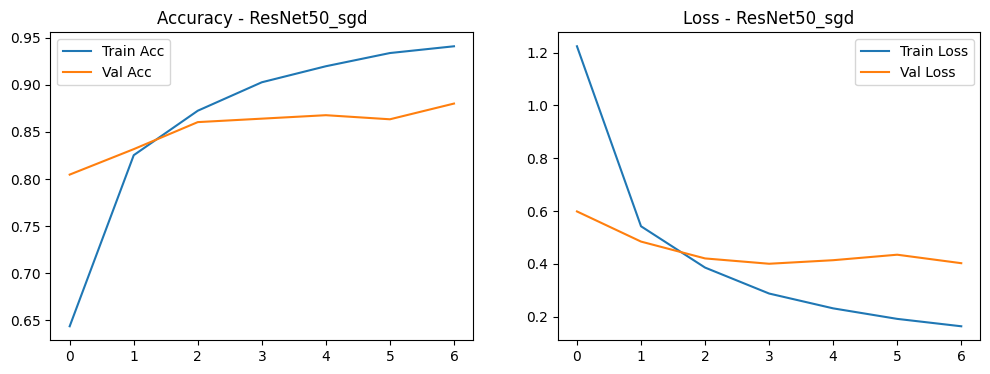

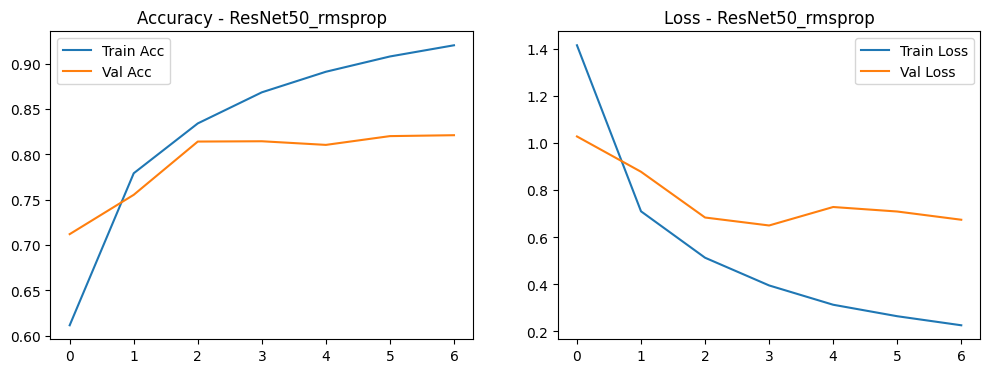

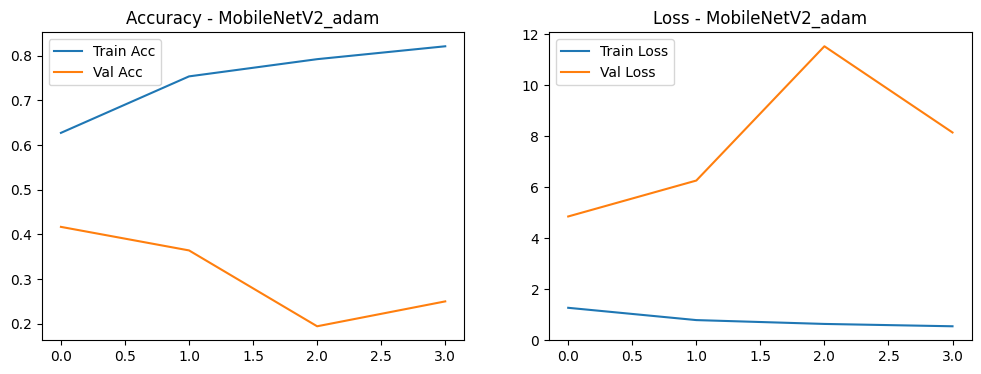

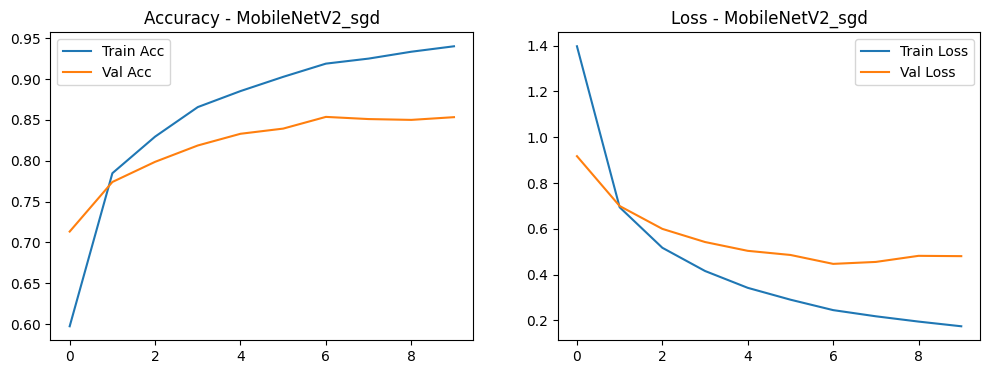

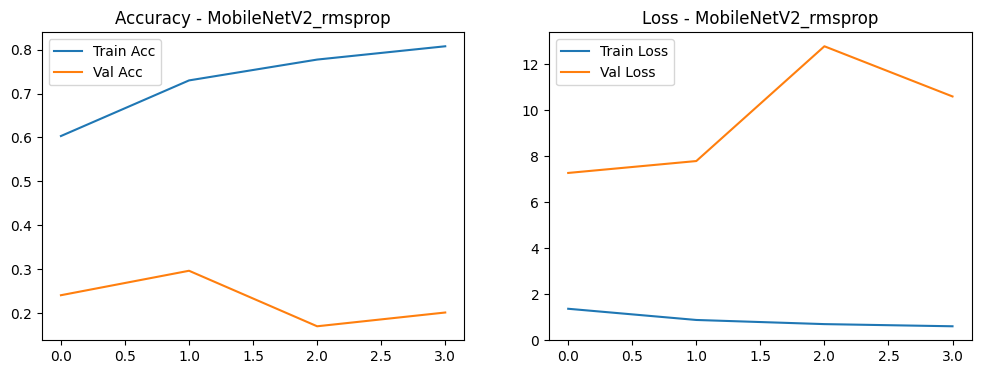

In [20]:
def plot_curves(histories):
    for name, (model, history) in histories.items():
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Acc')
        plt.plot(history.history['val_accuracy'], label='Val Acc')
        plt.title(f'Accuracy - {name}')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Val Loss')
        plt.title(f'Loss - {name}')
        plt.legend()
        plt.show()

plot_curves(history_dict)


Report

In [21]:
best_model_name = list(history_dict.keys())[0]  # pick best manually or by val_accuracy later
best_model, _ = history_dict[best_model_name]

# Get true & predicted labels
y_true = []
y_pred = []
for images, labels in val_ds:
    preds = best_model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# ✅ F1-Score Report (since classes > 10)
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n", report)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130

Test on an image

In [35]:
from google.colab import files

uploaded = files.upload()

Saving e.jpg to e (1).jpg


In [36]:
import PIL.Image
import matplotlib.pyplot as plt

def predict_image(image_path, model):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Add batch dimension

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    class_idx = np.argmax(score)

    # Display image and prediction
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Prediction: {class_names[class_idx]}\nConfidence: {100 * np.max(score):.2f}%")
    plt.show()

    return class_names[class_idx], float(np.max(score))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


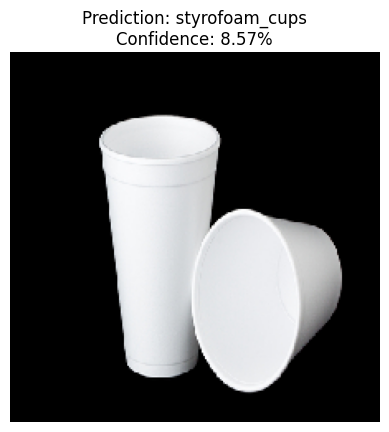

('styrofoam_cups', 0.08568108081817627)

In [37]:
# Get the filename
filename = list(uploaded.keys())[0]

# Predict using the best model from earlier
predict_image(filename, best_model)
